In [1]:
import torch
import numpy as np
import pandas as pd
import requests

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, DeepAR
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from data_retrieval import retrieve_data_from_url, prepare_data
from datetime import date as dt

import wandb

In [18]:
# CONFIGURATION Parameters
run_name = "smooth_jazz_5"
DATASET_PATH = 'kaiharuto/capstone/covid-data:' 
DATASET_VERSION = 'v4'
BUILD_NEW_DATASET = False

In [19]:
run = wandb.init(project="capstone", name=run_name, job_type="data_retrieval", reinit=True, config='run_config.yml')
# artifact = run.use_artifact('kaiharuto/capstone/covid-data:v3', type='dataset')
# artifact_dir = artifact.download()

wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
from datetime import date as dt

In [5]:
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'

In [6]:
# add import from downloaded artifact and only revert to downloading if the user wants to train on a new one
if BUILD_NEW_DATASET:
    try:
        #check local downloads first this will always fail for latest, triggering a new download
        with open("artifacts/covid-data:" + DATASET_VERSION + "/covid_json") as f:

            df = pd.DataFrame(json.load(f.read()))
        
        # register usage for tracking
        run.use_artifact(DATASET_PATH + DATASET_VERSION, type='dataset')
   
    except FileNotFoundError:

        #donwnload artifact files
        artifact= run.use_artifact(DATASET_PATH + DATASET_VERSION, type='dataset')
        file = artifact.download()
        
        with open(file + "/covid_json") as f:

             df = pd.DataFrame(json.load(f.read()))

else:
    df = retrieve_data_from_url(URL)
            
            

    #no local copy, donwnload raw data

#     if use_latest:
#         download latest
#     else:
#         check for version provided
#         (read api on artifacts)

# else:
#     df = retrieve_data_from_url(URL)
#     add code to log new artifact for data

In [7]:
data, x_df, info = prepare_data(df)

In [8]:
timestamp = dt.strftime(dt.today(), "%Y%m%d")

In [9]:
data_artifact = wandb.Artifact("covid-data", type="dataset", metadata={"retrieval" : timestamp})
# data_artifact.add_file('cleaned')
data_artifact.add_reference(URL, name="covid_json", checksum=True)
run.log_artifact(data_artifact)

In [10]:
import matplotlib.pyplot as plt

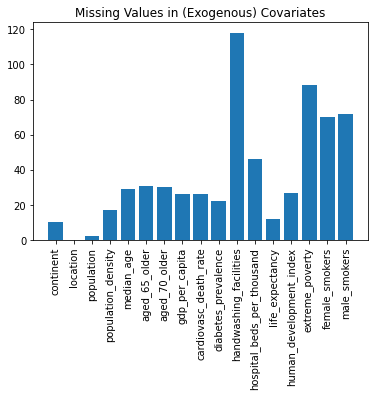

In [11]:
x_nans_sums = info["x_nan_sums"]

x_ax_labels = [k for k,v in x_nans_sums.items()]
x_ax_values = [v for k,v in x_nans_sums.items()]

plt.bar(x_ax_labels,x_ax_values)
plt.title("Missing Values in (Exogenous) Covariates")
plt.xticks(rotation = 90);

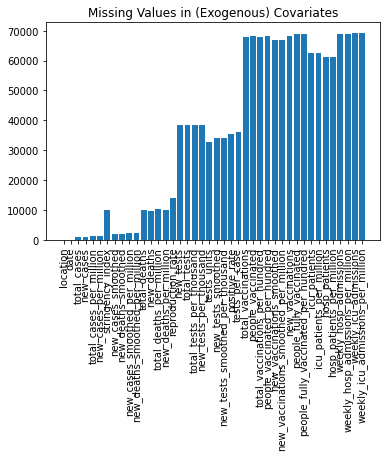

In [12]:
y_nans_sums = info["y_nan_sums"]

y_ax_labels = [k for k,v in y_nans_sums.items()]
y_ax_values = [v for k,v in y_nans_sums.items()]

plt.bar(y_ax_labels,y_ax_values)
plt.title("Missing Values in (Exogenous) Covariates")
plt.xticks(rotation = 90);

/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


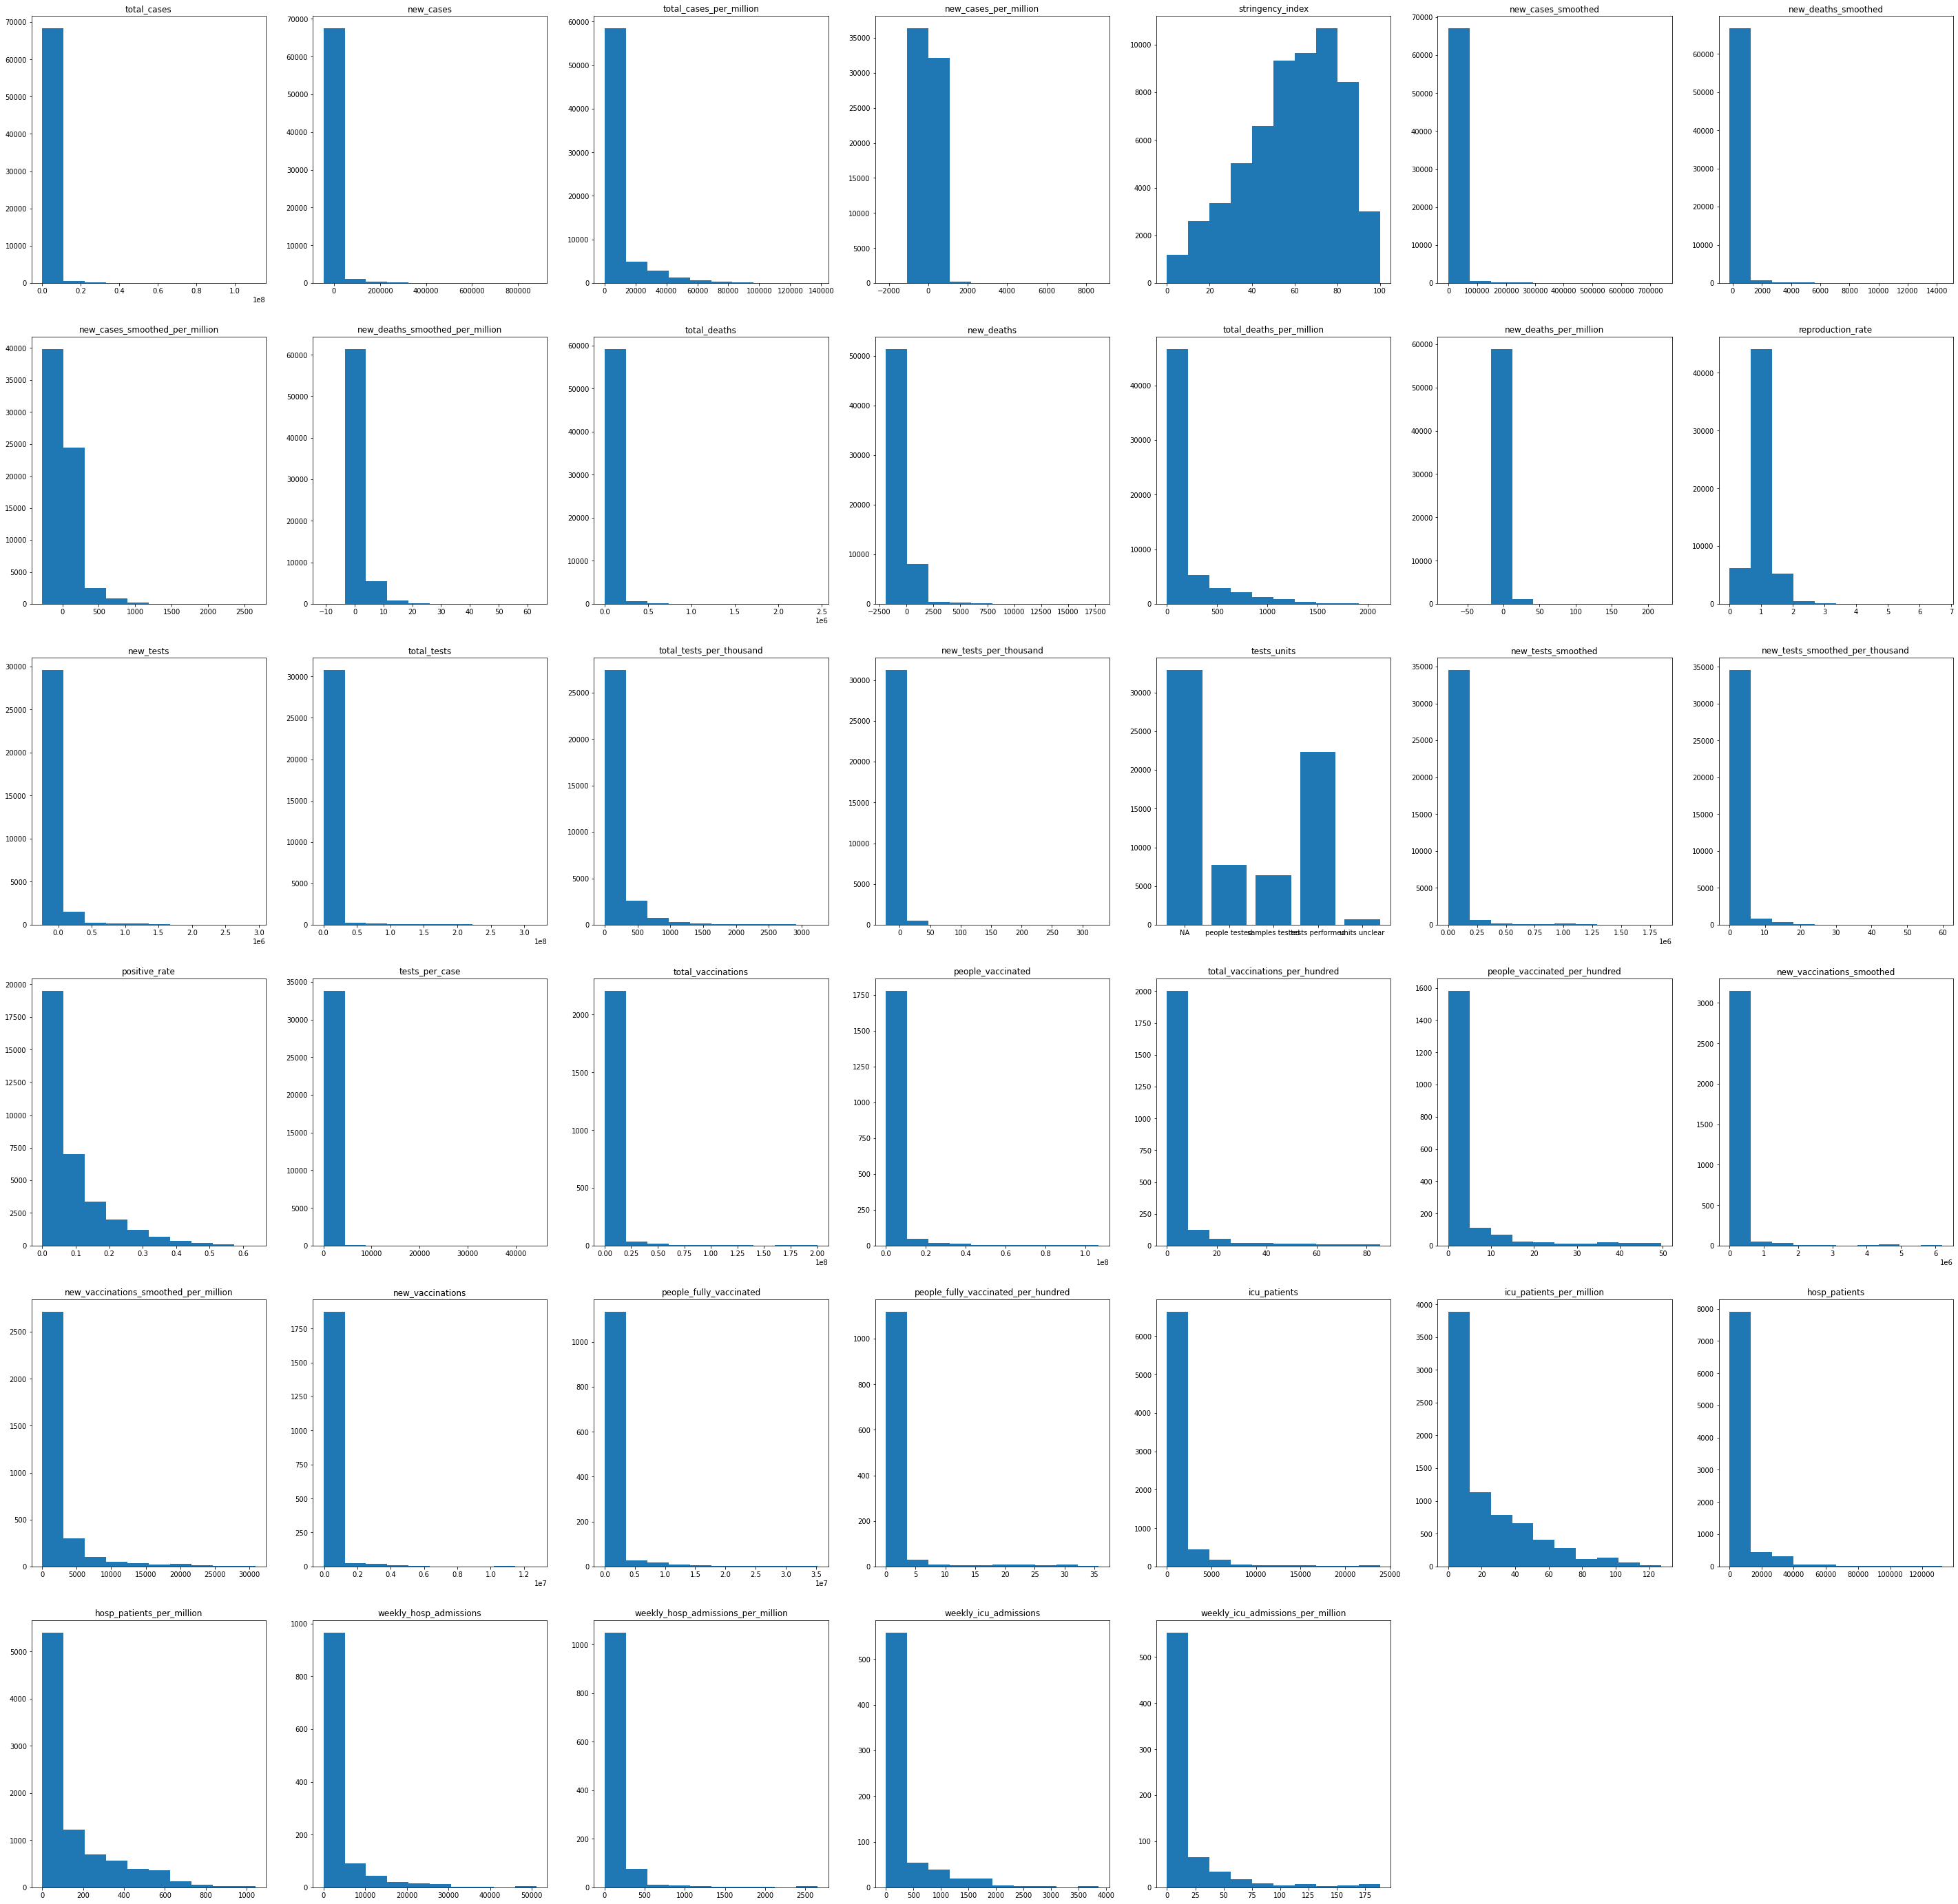

In [13]:
# plot histograms for all (potential) ys
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(50,50))
# ax.set_title("Distribution of Covariates")

i = 0
ys = info["y_nan_sums"].keys()
for x in ys:
    if(x in ['location', 'date']):
        continue
    
    else:
        
        i += 1
        ax = fig.add_subplot(6,7,i)

        if is_numeric_dtype(data[x]):

            ax.set_title(x)
            ax.hist(data[x],density=False)

        else:

            ax.bar(data.groupby(x).size().index, data.groupby(x).size())
            ax.set_title(x)
        
        
fig;

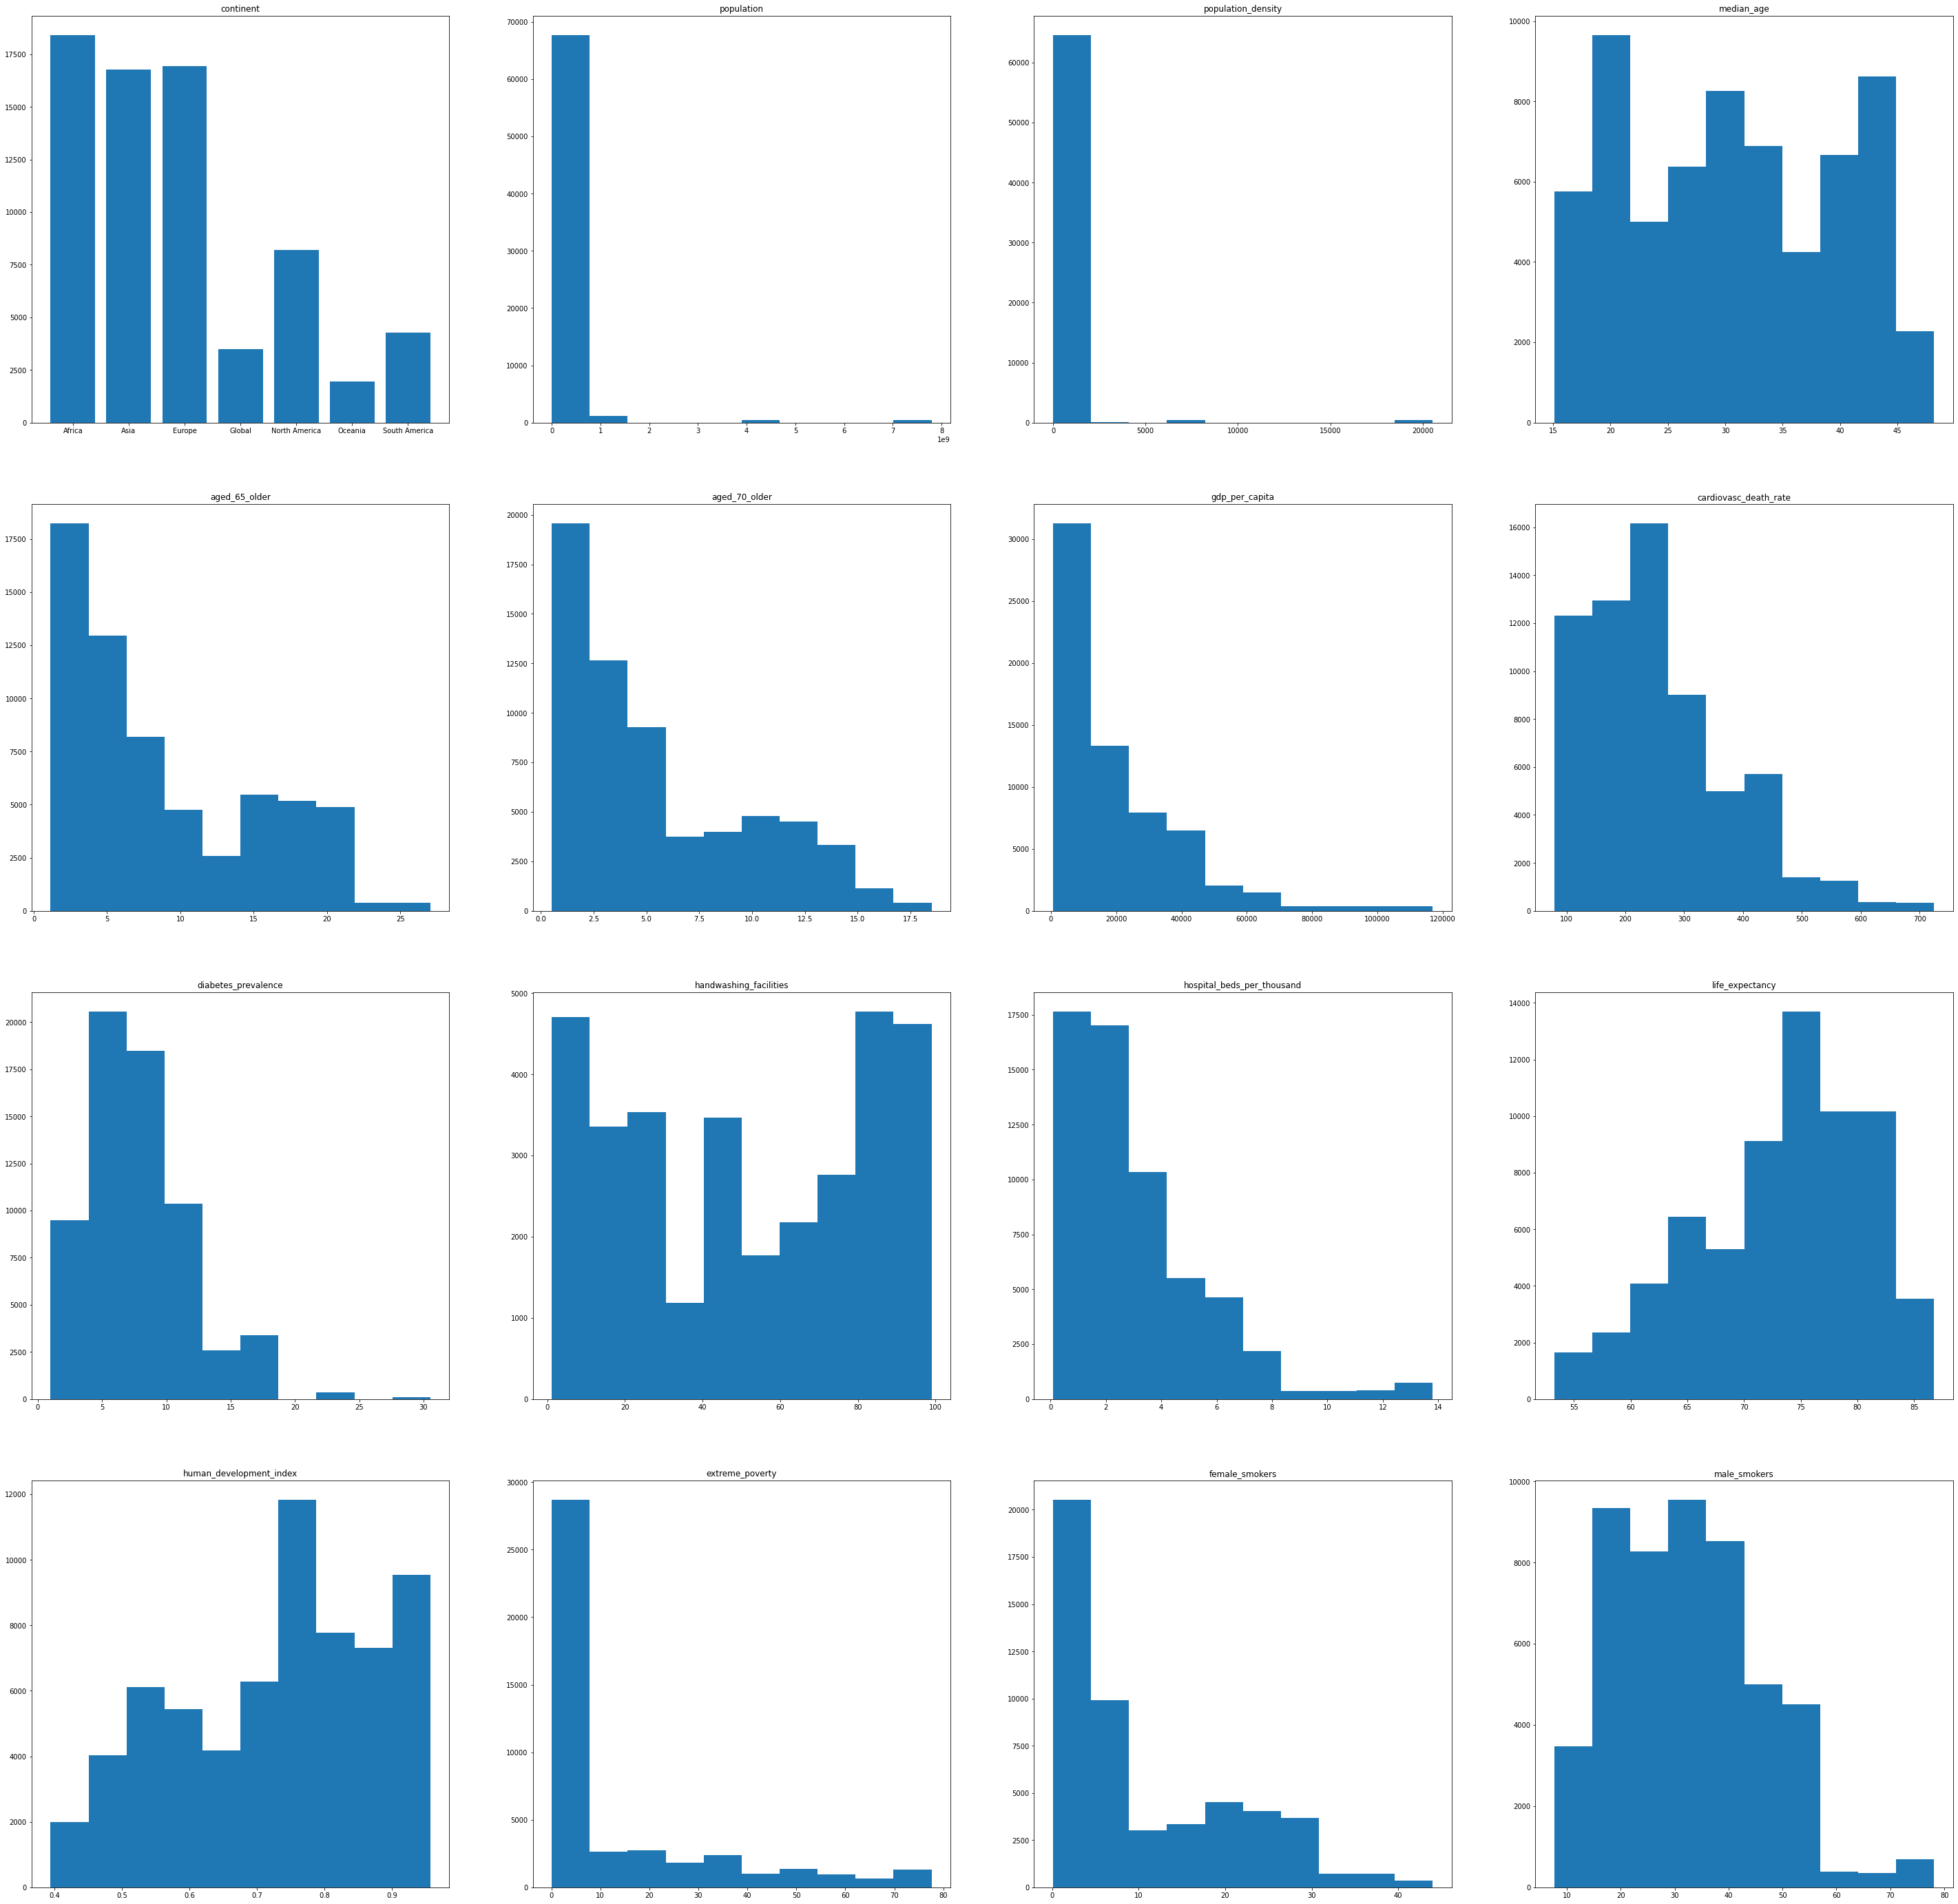

In [14]:
# plot histograms for all (potential) xs
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(50,50))
# ax.set_title("Distribution of Covariates")

i = 0
xs = info["x_nan_sums"].keys()
for x in xs:
    if(x in ['location', 'date']):
        continue
    else:
        
        i += 1
        ax = fig.add_subplot(4,4,i)

        if is_numeric_dtype(data[x]):

            ax.set_title(x)
            ax.hist(data[x],density=False)

        else:

            ax.bar(data.groupby(x).size().index, data.groupby(x).size())
            ax.set_title(x)
        
        
fig;

In [20]:
# set up wandb-based logging for prototype

wandb_log_prototype = WandbLogger(name=run_name + "_training",project="capstone")

# set model parameters for wandb
config = wandb.config

# model configs for wandb

# config.max_pred_length = 7 # predict at most two weeks
# config.max_encoder_length = 180  # use at most ~6 months as input
config.training_cutoff = data['time_idx'].max() - config.max_pred_length
# config.max_epochs = 50
# config.gradient_clip_val = 0.03
# config.learning_rate = .08
# config.hidden_size = 16
# # number of attention heads. Set to up to 4 for large datasets
# config.attention_head_size = 4
# config.dropout = 0.25  # between 0.1 and 0.3 are good values
# config.hidden_continuous_size = 4  # set to <= hidden_size
# config.output_size = 7  # 7 quantiles by default
# # reduce learning rate if no improvement in validation loss after x epochs
# config.reduce_on_plateau_patience = 4
config.targets = 'new_cases_smoothed'
config.static_reals = ['population','population_density','median_age','aged_65_older','aged_70_older',
                    'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
                    'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers']
config.time_varying_known_reals = ['time_idx','stringency_index', 'new_tests_smoothed',"new_vaccinations_smoothed", 
                                   "new_deaths_smoothed"
                                   ] # in reality unknown but could be used for conditional forecasts
config.transformation = "softplus"
config.impute_strategy = "median"
config.n_neighbors = 8
config.weights = "distance"

In [16]:
# see https://github.com/jdb78/pytorch-forecasting/issues/187#issuecomment-743797144
# simple imputation following https://www.kaggle.com/dansbecker/handling-missing-values

proto_data = data.copy()
# data.fillna({name: 0.0 for name in config.static_reals})
# proto_data.fillna({config.targets: 0.0}, inplace=True)
# drop "FSM" (Micronesia) Columns that only appeared as of 2021/01/21
proto_data.drop(index=data.loc[data.location == "FSM"].index, inplace=True)
# proto_data.drop(index=data.loc[data.location == "OWID_WRLD"].index, inplace=True)


# make new columns indicating what will be imputed
cols_with_missing = (col for col in [*config.static_reals, *config.time_varying_known_reals,
                                     config.targets]
                                 if proto_data[col].isnull().any())
for col in cols_with_missing:
    proto_data[col + '_was_missing'] = proto_data[col].isnull()



# Imputation
# imputer = SimpleImputer(strategy=config.impute_strategy)
# proto_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]] = pd.DataFrame(
#     imputer.fit_transform(proto_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]]))

proto_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]] = proto_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]].fillna(0) 


impute_dummies = [col for 
                  col in proto_data.columns if col.endswith("_was_missing")]

proto_data[impute_dummies] = proto_data[impute_dummies].astype("str").astype("category")

# if the dataset still contains missing values for the target, count them and drop them 
missing_targets = proto_data.loc[proto_data[config.targets].isna()][["location","date"]].copy(deep=True)
proto_data.drop(index=missing_targets.index, inplace=True)



training = TimeSeriesDataSet(
    proto_data[lambda x: x.time_idx <= config.training_cutoff],
    time_idx='time_idx',
    target=config.targets,
    group_ids=['location'],
    min_encoder_length=int(config.max_encoder_length // 2),
    max_encoder_length=config.max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=config.max_pred_length,
    static_categoricals=['location', 'continent', 'tests_units'], 
    static_reals = config.static_reals,
    time_varying_known_categoricals=['month', *impute_dummies], #allow for missings to be flagged on country-level over time - needs to be assumed in forecasts
    time_varying_known_reals=config.time_varying_known_reals,
    target_normalizer=GroupNormalizer(groups=['location'], transformation=config.transformation),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, proto_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)
# print("Dropping the following for missing target values: \n\n ", missing_targets)

/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 14 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those seriesFirst 10 removed groups: [{'__group_id__location': 'AIA'}, {'__group_id__location': 'BMU'}, {'__group_id__location': 'CYM'}, {'__group_id__location': 'FRO'}, {'__group_id__location': 'GGY'}, {'__group_id__location': 'GIB'}, {'__group_id__location': 'GRL'}, {'__group_id__location': 'IMN'}, {'__group_id__location': 'JEY'}, {'__group_id__location': 'MAC'}]
  warnings.warn(
/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:863: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length is too large for 14 series/groups

In [17]:
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
baseline = (actuals - baseline_predictions).abs().mean().item()
baseline

505.331298828125

In [18]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    num_processes=8,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=config.gradient_clip_val,
    max_epochs=config.max_epochs,
    logger=wandb_log_prototype

)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=config.learning_rate,
    hidden_size=config.hidden_size,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=config.attention_head_size,
    dropout=config.dropout,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=config.hidden_continuous_size,  # set to <= hidden_size
    output_size=config.output_size,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=config.reduce_on_plateau_patience
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}")

/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: num_processes is only used for distributed_backend="ddp_cpu". Ignoring it.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 35.6


In [19]:
    # not meaningful for finding the learning rate but otherwise very important
print(config.learning_rate,)
print(config.hidden_size),  # most important hyperparameter apart from learning rate
# print(# number of attention heads. Set to up to 4 for large datasets)
print(config.attention_head_size)
print(config.dropout)  # between 0.1 and 0.3 are good values)
print(config.hidden_continuous_size)  # set to <= hidden_size)
print(config.output_size)  # 7 quantiles by default)
print(QuantileLoss())
print(    # reduce learning rate if no improvement in validation loss after x epochs)
config.reduce_on_plateau_patience)
print(training)

0.03
16
4
0.25
4
7
QuantileLoss()
8


In [20]:
wandb.config

{'max_pred_length': 7, 'max_encoder_length': 180, 'max_epochs': 50, 'gradient_clip_val': 0.03, 'learning_rate': 0.03, 'hidden_size': 16, 'attention_head_size': 4, 'dropout': 0.25, 'hidden_continuous_size': 4, 'reduce_on_plateau_patience': 8, 'output_size': 7, 'transformation': 'softplus', 'impute_strategy': 'median', 'n_neighbors': 8, 'weights': 'distance', 'training_cutoff': 408, 'targets': 'new_cases_smoothed', 'static_reals': ['population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers', 'male_smokers'], 'time_varying_known_reals': ['time_idx', 'stringency_index', 'new_tests_smoothed', 'new_vaccinations_smoothed', 'new_deaths_smoothed']}

In [21]:


# # see https://github.com/jdb78/pytorch-forecasting/issues/187#issuecomment-743797144
# # simple imputation by replacing NaNs with 0
# proto_data = data.fillna({name: 0.0 for name in config.static_reals})
# proto_data.fillna({config.targets: 0.0}, inplace=True)


# training = TimeSeriesDataSet(
#     proto_data[lambda x: x.time_idx <= config.training_cutoff],
#     time_idx='time_idx',
#     target=config.targets,
#     group_ids=['location'],
#     min_encoder_length=int(config.max_encoder_length // 2),
#     max_encoder_length=config.max_encoder_length,
#     min_prediction_length=1,
#     max_prediction_length=config.max_pred_length,
#     static_categoricals=['location', 'continent', 'tests_units'],
#     static_reals = config.static_reals,
#     time_varying_known_categoricals=['month'],
#     time_varying_known_reals=['time_idx', 
#                               #'stringency_index', 'new_tests', unknown but could be used for conditional forecasts
#                              ],
#     target_normalizer=GroupNormalizer(groups=['location'], transformation="softplus"),
#     add_relative_time_idx=True,
#     add_target_scales=True,
#     add_encoder_length=True,
#     allow_missings=True
# )

# # create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
# validation = TimeSeriesDataSet.from_dataset(training, proto_data, predict=True, stop_randomization=True)

# # create dataloaders for model
# batch_size = 128  # set this between 32 to 128
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [22]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
# actuals = torch.cat([y for x, y in iter(val_dataloader)])
# baseline_predictions = Baseline().predict(val_dataloader)
# (actuals - baseline_predictions).abs().mean().item()

In [23]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    num_processes=8,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=config.gradient_clip_val,
    max_epochs=config.max_epochs,
    logger=wandb_log_prototype

)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=config.learning_rate,
    hidden_size=config.hidden_size,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=config.attention_head_size,
    dropout=config.dropout,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=config.hidden_continuous_size,  # set to <= hidden_size
    output_size=config.output_size,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=config.reduce_on_plateau_patience
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 35.6k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.6 K 
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 8.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

suggested learning rate: 0.021379620895022322


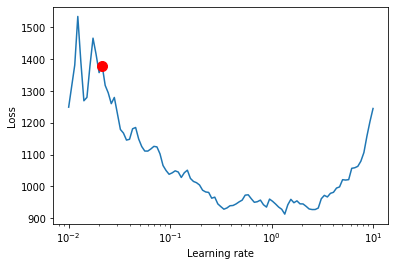

<ipython-input-24-4fb00dbde550>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [24]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-2,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [25]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader)

wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.6 K 
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 8.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 1:   1%|▏         | 7/542 [00:07<-1:59:18, -12.67it/s, loss=1892.551, v_num=7qa6, train_loss_step=2.01e+3, train_loss_epoch=1.11e+3]

Exception ignored in: <function tqdm.__del__ at 0x7f0a5e12b940>
Traceback (most recent call last):
  File "/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/tqdm/std.py", line 1325, in close
    fp_write('')
  File "/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/tqdm/std.py", line 1322, in fp_write
    self.fp.write(_unicode(s))
  File "/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/tqdm/utils.py", line 143, in inner
    return func(*args, **kwargs)
  File "/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/wandb/sdk/lib/redirect.py", line 91, in new_write
    cb(name, data)
  File "/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/li

Epoch 1: 100%|█████████▉| 541/542 [08:56<00:01,  1.21s/it, loss=398.330, v_num=7qa6, train_loss_step=527, train_loss_epoch=1.11e+3]       
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████▉| 541/542 [08:57<00:01,  1.22s/it, loss=301.365, v_num=7qa6, train_loss_step=354, train_loss_epoch=524, val_loss=347]        
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 541/542 [08:59<00:01,  1.22s/it, loss=301.510, v_num=7qa6, train_loss_step=283, train_loss_epoch=318, val_loss=283]      
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 541/542 [09:00<00:01,  1.22s/it, loss=210.371, v_num=7qa6, train_loss_step=189, train_loss_epoch=266, val_loss=279]    
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 541/542 [09:00<00:01,  1.22s/it, loss=175.784, v_num=7qa6, train_loss_step=200, train_loss_epoch=229, val_loss=374]    
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████▉| 541/542 [08:59<00:01,  1.22s/it, loss=196.966, v_num=7qa6, train_loss_step=133, train_loss

1

In [26]:
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=config.max_epochs,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=config.reduce_on_plateau_patience,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [6]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


NameError: name 'best_model_path' is not defined

In [30]:
# run = wandb.init(run_name +"_save")
artifact = run.use_artifact('kaiharuto/capstone/smooth_jazz_5:latest', type='model')
best_model_path=  artifact.download()
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path + "/epoch=23.ckpt")
# run.log_artifact(model_artifact) 

In [31]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
trained_model = (actuals - predictions).abs().mean().item()
trained_model

NameError: name 'val_dataloader' is not defined

In [39]:
baseline

505.331298828125

In [40]:
if (trained_model >= baseline):
    print("try again")
else:
    print("Nice")

Nice


In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [32]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [11]:
torch.save(best_tft.state_dict(), run_name + "best.pkl")
model_artifact = wandb.Artifact(run_name, type="model", metadata={"run_date" : timestamp, "MAE": trained_model})
model_artifact.add_file(best_model_path)
run.log_artifact(model_artifact)

wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


NameError: name 'best_tft' is not defined

In [21]:
proto_data = data.copy()
# data.fillna({name: 0.0 for name in config.static_reals})
# proto_data.fillna({config.targets: 0.0}, inplace=True)
# drop "FSM" (Micronesia) Columns that only appeared as of 2021/01/21
proto_data.drop(index=data.loc[data.location == "FSM"].index, inplace=True)
# proto_data.drop(index=data.loc[data.location == "OWID_WRLD"].index, inplace=True)


# make new columns indicating what will be imputed
cols_with_missing = (col for col in [*config.static_reals, *config.time_varying_known_reals,
                                     config.targets]
                                 if proto_data[col].isnull().any())
for col in cols_with_missing:
    proto_data[col + '_was_missing'] = proto_data[col].isnull()



# Imputation
# imputer = SimpleImputer(strategy=config.impute_strategy)
# proto_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]] = pd.DataFrame(
#     imputer.fit_transform(proto_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]]))

proto_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]] = proto_data[[*config.static_reals, *config.time_varying_known_reals, config.targets]].fillna(0) 


impute_dummies = [col for 
                  col in proto_data.columns if col.endswith("_was_missing")]

proto_data[impute_dummies] = proto_data[impute_dummies].astype("str").astype("category")

# if the dataset still contains missing values for the target, count them and drop them 
missing_targets = proto_data.loc[proto_data[config.targets].isna()][["location","date"]].copy(deep=True)
proto_data.drop(index=missing_targets.index, inplace=True)


In [22]:
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'
df = retrieve_data_from_url(URL)
data, x_df, info = prepare_data(df)

In [23]:
data = data.loc[data.time_idx > proto_data.time_idx.max() - config.max_encoder_length] #only predict new data

,location,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,...,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,extreme_poverty,female_smokers,male_smokers,time_idx,month
0,AFG,2021-03-01,55580.0,5.0,1427.752,0.128,NaN,15.286,0.429,0.393,...,9.59,37.746,0.500,64.83,0.511,NaN,NaN,NaN,417,3
1,ALB,2021-03-01,99062.0,1153.0,34422.823,400.653,NaN,1010.714,15.714,351.211,...,10.08,NaN,2.890,78.57,0.795,1.1,7.100,51.200,417,3
2,DZA,2021-03-01,111764.0,164.0,2548.719,3.740,NaN,178.714,3.286,4.075,...,6.73,83.741,1.900,76.88,0.748,0.5,0.700,30.400,417,3
3,AND,2021-03-01,10672.0,27.0,138122.047,349.447,NaN,29.857,0.000,386.425,...,7.97,NaN,NaN,83.73,0.868,NaN,29.000,37.800,417,3
4,AGO,2021-03-01,20499.0,21.0,623.709,0.639,NaN,24.286,1.000,0.739,...,3.94,26.664,NaN,61.15,0.581,NaN,NaN,NaN,417,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,OWID_INT,2021-09-01,721.0,0.0,NaN,NaN,NaN,0.000,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,423,9
1403,OWID_NAM,2021-09-01,32249792.0,86315.0,54469.357,145.785,NaN,86222.429,2908.571,145.628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,423,9
1404,OWID_OCE,2021-09-01,32329.0,21.0,757.513,0.492,NaN,15.000,0.286,0.351,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,423,9
1405,OWID_SAM,2021-09-01,17357779.0,82808.0,40295.729,192.237,NaN,71429.000,1759.429,165.821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,423,9


In [24]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - config.max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, config.max_pred_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
decoder_data[impute_dummies] = "False"
decoder_data[impute_dummies] = decoder_data[impute_dummies].astype(str).astype("category")

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

Index(['location', 'date', 'total_cases', 'new_cases',
       'total_cases_per_million', 'new_cases_per_million', 'stringency_index',
       'new_cases_smoothed', 'new_deaths_smoothed',
       'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million',
       'total_deaths', 'new_deaths', 'total_deaths_per_million',
       'new_deaths_per_million', 'reproduction_rate', 'new_tests',
       'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
       'tests_units', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'new_vaccinations_smoothed',
       'new_vaccinations_smoothed_per_million', 'new_vaccinations',
       'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
       'icu_patients', 'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_hos

In [33]:
# new_prediction_data[impute_dummies] = new_prediction_data[impute_dummies].fillna("False")
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True, ignore_na=True, add_nan=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);



/home/kharuto/Documents/projects/b-kaindl/udacity/capstone/cov_env/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:773: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


KeyError: "Unknown category 'nan' encountered. Set `add_nan=True` to allow unknown categories"

In [35]:
run.finish()

# 2nd Try - More Sophisticated Data Cleaning & Value Imputation

In [ ]:
plt.hist(data.groupby('location').nunique()['date']);

In [ ]:
plt.bar(data.groupby('date').nunique()['location'].index, data.groupby('date').nunique()['location']);

Given the high number of missing values, we might be tempted to retry model fitting without excessively sparse features (e.g. `handwashing_facilities`).
See [this article](https://www.wandb.com/articles/pytorch-lightning-with-weights-biases) to leverage wandb.

In [ ]:
targets = 'new_cases'

reals = ['population','population_density','median_age','aged_65_older','aged_70_older',
                    'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
                    'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers']

In [ ]:
run = wandb.init(project='capstone')

In [ ]:
# check reals with most missing values
# remove reals with more than 50%  NaNs
clean_haze_data = data.copy()
high_missing = clean_haze_data[reals].isna().mean()[clean_haze_data[reals].isna().mean() > .5].index
print("removing: ", high_missing)
for idx in high_missing:
    reals.remove(idx)

In [ ]:
# set up wandb-based logging for prototype

wandb_log_ch = WandbLogger(name="clean_haze",project="capstone")

# set model parameters for wandb
config = wandb.config

# model configs for wandb

config.max_pred_length = 7 # predict at most two weeks
config.max_encoder_length = 60  # use at most 2 months as input
config.training_cutoff = data['time_idx'].max() - config.max_pred_length
config.max_epochs = 50
config.gradient_clip_val = 0.1
config.learning_rate = 0.03
config.hidden_size = 16
# number of attention heads. Set to up to 4 for large datasets
config.attention_head_size = 1
config.dropout = 0.1  # between 0.1 and 0.3 are good values
config.hidden_continuous_size = 8  # set to <= hidden_size
config.output_size = 7  # 7 quantiles by default
# reduce learning rate if no improvement in validation loss after x epochs
config.reduce_on_plateau_patience = 4
config.targets = 'new_cases'
config.static_reals = reals
config.dataset = "clean_haze"
config.transformation = "softplus"
config.max_epochs=50

In [ ]:


# see https://github.com/jdb78/pytorch-forecasting/issues/187#issuecomment-743797144
# simple imputation by replacing NaNs with 0
clean_haze_data.fillna({name: 0.0 for name in config.static_reals}, inplace=True)
clean_haze_data.fillna({config.targets: 0.0}, inplace=True)


training = TimeSeriesDataSet(
    clean_haze_data[lambda x: x.time_idx <= config.training_cutoff],
    time_idx='time_idx',
    target=config.targets,
    group_ids=['location'],
    min_encoder_length=int(config.max_encoder_length // 2),
    max_encoder_length=config.max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=config.max_pred_length,
    static_categoricals=['location', 'continent', 'tests_units'],
    static_reals = config.static_reals,
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=['time_idx', 
                              #'stringency_index', 'new_tests', unknown but could be used for conditional forecasts
                             ],
    target_normalizer=GroupNormalizer(groups=['location'], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, clean_haze_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    num_processes=8,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=config.gradient_clip_val,
    max_epochs=config.max_epochs,
    logger=wandb_log_ch

)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=config.learning_rate,
    hidden_size=config.hidden_size,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=config.attention_head_size,
    dropout=config.dropout,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=config.hidden_continuous_size,  # set to <= hidden_size
    output_size=config.output_size,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=config.reduce_on_plateau_patience
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-2
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    
)

In [ ]:
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=config.max_epochs,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=config.reduce_on_plateau_patience,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);